## Script to perform cross-validation on UKB and to analyse contribution of the metadata

In [1]:
import pandas as pd
import scipy.stats as stats
import numpy as np
from sklearn import linear_model
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, StratifiedShuffleSplit
from sklearn import metrics
from sklearn.metrics import plot_roc_curve, confusion_matrix
import matplotlib.pyplot as plt

In [2]:
MI_cases =  pd.read_csv('../results_test/ids_MI_4_test_mtdt_preds.csv') 
non_MI_cases =  pd.read_csv('../results_test/non_stroke_MI_ids_mtdt_preds.csv') 
mtdt_MI = pd.read_csv('../input_data/ids/ids_MI_4_test_mtdt.csv')
mtdt_non_MI = pd.read_csv('../input_data/ids/non_stroke_MI_ids_mtdt.csv')

In [3]:
print(len(MI_cases))
print(len(non_MI_cases))
print(len(mtdt_MI))
print(len(mtdt_non_MI))

992
59181
1211
70022


## MI cases

In [4]:
mtdt_MI = mtdt_MI[mtdt_MI.ID.isin(MI_cases.ID.apply(lambda x:x.split('_')[0]))]
mtdt_MI.index = range(len(mtdt_MI))

In [5]:
mtdt_MI = mtdt_MI.sort_values(by=['ID'])
MI_cases = MI_cases.sort_values(by=['ID'])
MI_cases = pd.concat([MI_cases, 
                      mtdt_MI[['sex', 'dbpa', 'sbpa', 'ss', 'ads', 'bmi', 'age', 'hba1c', 'chol', 'glucose']]],axis=1)

In [6]:
print(len(MI_cases))

992


## Non-MI cases

In [7]:
mtdt_non_MI = mtdt_non_MI[mtdt_non_MI.ID.isin(non_MI_cases.ID.apply(lambda x:x.split('_')[0]))]
mtdt_non_MI.index = range(len(mtdt_non_MI))

In [8]:
mtdt_non_MI = mtdt_non_MI.sort_values(by=['ID'])
non_MI_cases = non_MI_cases.sort_values(by=['ID'])
non_MI_cases = pd.concat([non_MI_cases, 
                      mtdt_non_MI[['sex', 'dbpa', 'sbpa', 'ss', 'ads', 'bmi', 'age', 'hba1c', 'chol', 'glucose']]],axis=1)

In [9]:
print(len(non_MI_cases))

59181


## Training linear regressor

In [10]:
# Adding labels
non_MI_cases['label'] = np.zeros((len(non_MI_cases),1))
MI_cases['label'] = np.ones((len(MI_cases),1))

# Creating data and labels
all_vals = pd.concat([non_MI_cases.sample(n=1000), MI_cases])

# Taking LVM/LVEDV or only demographics
X = all_vals.iloc[:,1:-1].values
# Filename
filename_plot = 'lvm_lvedv'
# labels
y = all_vals.iloc[:,-1].values

# Rescaling inputs
scaler = RobustScaler()
X = scaler.fit_transform(X)

In [11]:
variables = all_vals.columns
# variables = ['LVEDV', 'LVM', 'Sex', 'Diastolic Pressure', 'Systolic Pressure', 'Smoking Status', 'Alcohol Consumption', 'Body Mass Index', 'Age',
#        'hba1c', 'Cholesterol', 'Glucose']

## Cross validation

In [12]:
# Creating a function to report confusion metrics
def confusion_metrics (conf_matrix):
    
    # save confusion matrix and slice into four pieces   
    TP = conf_matrix[1][1]
    TN = conf_matrix[0][0]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]    
    print('True Positives:', TP)
    print('True Negatives:', TN)
    print('False Positives:', FP)
    print('False Negatives:', FN)
    
    # calculate accuracy
    conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
    
    # calculate mis-classification
    conf_misclassification = 1 - conf_accuracy
    
    # calculate the sensitivity
    conf_sensitivity = (TP / float(TP + FN))    # calculate the specificity
    conf_specificity = (TN / float(TN + FP))
    
    # calculate precision
    conf_precision = (TN / float(TN + FP))    # calculate f_1 score
    conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))    
    print(f'Accuracy: {round(conf_accuracy,2)}') 
    print(f'Mis-Classification: {round(conf_misclassification,2)}') 
    print(f'Sensitivity: {round(conf_sensitivity,2)}') 
    print(f'Specificity: {round(conf_specificity,2)}') 
    print(f'Precision: {round(conf_precision,2)}')
    print(f'f_1 Score: {round(conf_f1,2)}')
    
    return conf_accuracy, conf_sensitivity, conf_specificity, conf_precision, conf_f1

Fold:  0
AUC:  0.8342
True Positives: 71
True Negatives: 73
False Positives: 27
False Negatives: 29
Accuracy: 0.72
Mis-Classification: 0.28
Sensitivity: 0.71
Specificity: 0.73
Precision: 0.73
f_1 Score: 0.72
--------------------------------------------------
Fold:  1
AUC:  0.7845999999999999
True Positives: 72
True Negatives: 68
False Positives: 32
False Negatives: 28
Accuracy: 0.7
Mis-Classification: 0.3
Sensitivity: 0.72
Specificity: 0.68
Precision: 0.68
f_1 Score: 0.7
--------------------------------------------------
Fold:  2
AUC:  0.7829
True Positives: 71
True Negatives: 73
False Positives: 27
False Negatives: 29
Accuracy: 0.72
Mis-Classification: 0.28
Sensitivity: 0.71
Specificity: 0.73
Precision: 0.73
f_1 Score: 0.72
--------------------------------------------------
Fold:  3
AUC:  0.815
True Positives: 70
True Negatives: 76
False Positives: 24
False Negatives: 30
Accuracy: 0.73
Mis-Classification: 0.27
Sensitivity: 0.7
Specificity: 0.76
Precision: 0.76
f_1 Score: 0.73
--------

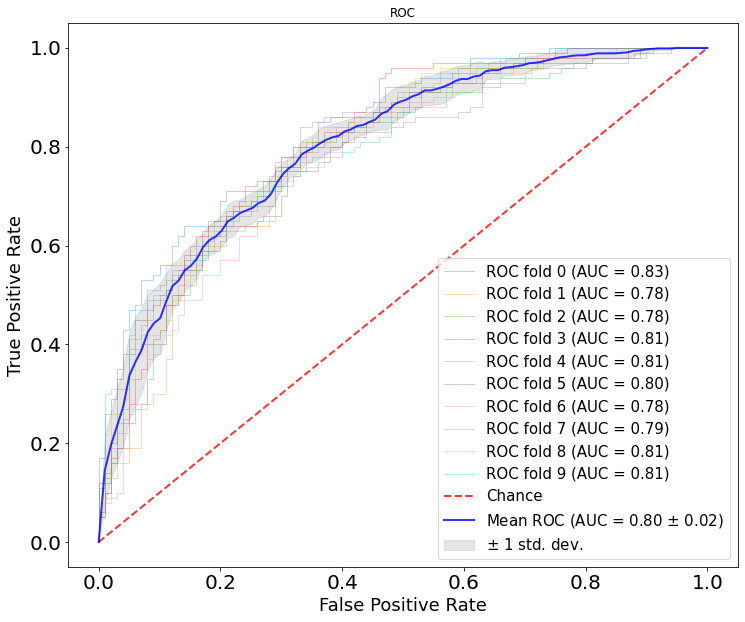

In [13]:
thrs = 0.5

# Run classifier with cross-validation and plot ROC curves

# cv = StratifiedKFold(n_splits=10)
cv = StratifiedShuffleSplit(n_splits=10, random_state=12)

classifier = linear_model.LogisticRegression()
# classifier = MLPClassifier(solver='sgd', alpha=1e-5, max_iter=1500)


tprs = []
aucs = []
accuracies = []
sensitivities = []
specificities = []
precisions = []
f1s = []

mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(12, 10))

for i, (train, test) in enumerate(cv.split(X, y)):
       
    classifier.fit(X[train], y[train])
    viz = plot_roc_curve(classifier, X[test], y[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    auc = viz.roc_auc
    ### Sensitivity/Specificity/TN/FP/FN
    y_pred = classifier.predict(X[test])
    cm = confusion_matrix(y[test], y_pred>thrs)   
    print('Fold: ', i)
    print('AUC: ', auc)
    accuracy, sensitivity, specificity, precision, f1 = confusion_metrics(cm)
    print('-'*50)
    ############
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(auc)
    accuracies.append(accuracy)
    sensitivities.append(sensitivity)
    specificities.append(specificity)
    precisions.append(precision)
    f1s.append(f1)
    
print('Final results: ')
print(f'Accuracy: {round(np.mean(accuracies, axis=0),2)} +/- {round(np.std(accuracies, axis=0),2)} ') 
print(f'Sensitivity: {round(np.mean(sensitivities, axis=0),2)} +/- {round(np.std(sensitivities, axis=0),2)} ') 
print(f'Specificity: {round(np.mean(specificities, axis=0),2)} +/- {round(np.std(specificities, axis=0),2)} ') 
print(f'Precision: {round(np.mean(precisions, axis=0),2)} +/- {round(np.std(precisions, axis=0),2)} ')
print(f'f_1 Score: {round(np.mean(f1s, axis=0),2)} +/- {round(np.std(f1s, axis=0),2)} ')

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)


ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="ROC")
ax.legend(loc="lower right", fontsize=15)
ax.tick_params(labelsize=20)
ax.set_ylabel('True Positive Rate', fontsize=18)
ax.set_xlabel('False Positive Rate', fontsize=18)
# ax.set_title('ROC - Using LVM/LVEDV', fontsize=18)
plt.savefig(filename_plot + '.pdf')
plt.savefig(filename_plot + '.png')
plt.show()

## One model

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.10, 
                                                    random_state=42)

In [15]:
# Regression
## Info: https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6

lm = linear_model.LogisticRegression()
model = lm.fit(X_train, y_train)

In [16]:
predictions = lm.predict(X_test)
probs = lm.predict_proba(X_test)
print(predictions)

[0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0.
 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1.
 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1.
 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0.
 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1.
 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1.
 0. 1. 0. 0. 0. 1. 1. 0.]


In [17]:
# https://scikit-learn.org/dev/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html
coefs = pd.DataFrame(np.transpose(lm.coef_), columns=['Coefficients'], index=variables.values[1:-1]) # variables.values[1:-1]

In [18]:
coefs

,Coefficients
LVEDV,0.845680
LVM,1.581963
sex,-1.259295
dbpa,-0.194497
sbpa,0.113410
ss,0.226120
ads,-0.511283
bmi,-0.125977
age,1.239031
hba1c,0.091779


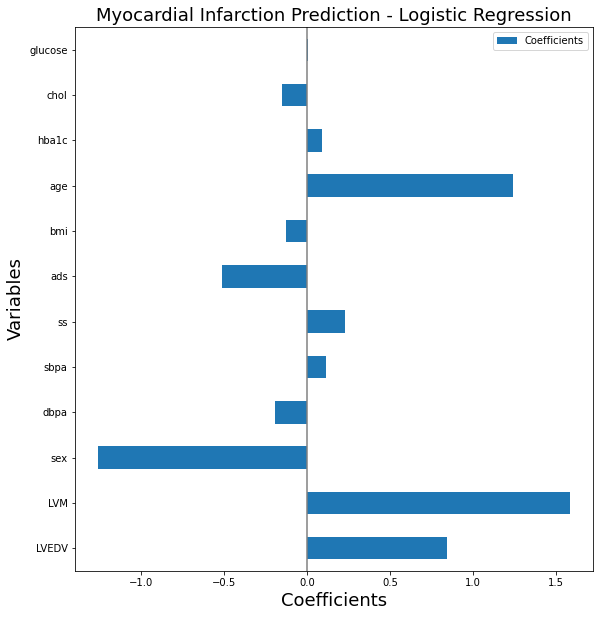

In [19]:
coefs.plot(kind='barh', figsize=(12, 10))
plt.title('Myocardial Infarction Prediction - Logistic Regression', fontsize=18)
plt.axvline(x=0, color='.5')
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
plt.xlabel('Coefficients', fontsize=18)
plt.ylabel('Variables', fontsize=18)
plt.savefig('coefficients_LR.pdf')
plt.savefig('coefficients_LR.png')
plt.subplots_adjust(left=.3)

In [20]:
# Confusion matrix
cm = metrics.confusion_matrix(y_test, predictions)
# calculate scores
roc_auc = metrics.roc_auc_score(y_test, probs[:,1])
# calculate roc curves
fpr, tpr, _ = metrics.roc_curve(y_test, probs[:,1])

True Positives: 73
True Negatives: 67
False Positives: 30
False Negatives: 30
Accuracy: 0.7
Mis-Classification: 0.3
Sensitivity: 0.71
Specificity: 0.69
Precision: 0.69
f_1 Score: 0.7


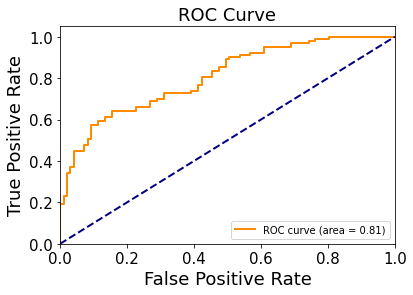

In [21]:
# Confusion matrix
confusion_metrics(cm)

# Plot AUC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC Curve', fontsize=18)
plt.legend(loc="lower right")
plt.show()

## Statistical significance

In [22]:
non_MI_cases = non_MI_cases.sample(n=1000)

In [23]:
# LVEDV
plt.figure(figsize=(12, 10))
non_MI_cases.iloc[:,1].hist()
plt.title('Non MI cases', fontsize=18)
plt.xlabel('LVEDV (ml)', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.tick_params(labelsize=15)
plt.savefig('distro_non_MI_cases_LVEDV.pdf')
plt.close()
# LVM
plt.figure(figsize=(12, 10))
non_MI_cases.iloc[:,2].hist()
plt.title('Non MI cases', fontsize=18)
plt.xlabel('LVM (gr)', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.tick_params(labelsize=15)
plt.savefig('distro_non_MI_cases_LVM.pdf')
plt.close()

In [24]:
# LVEDV
plt.figure(figsize=(12, 10))
MI_cases.iloc[:,1].hist()
plt.title('MI cases', fontsize=18)
plt.xlabel('LVEDV (ml)', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.tick_params(labelsize=15)
plt.savefig('distro_MI_cases_LVEDV.pdf')
plt.close()

# LVM
plt.figure(figsize=(12, 10))
MI_cases.iloc[:,2].hist()
plt.title('MI cases', fontsize=18)
plt.xlabel('LVM (gr)', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.tick_params(labelsize=15)
plt.savefig('distro_MI_cases_LVM.pdf')
plt.close()

In [25]:
res_lvedv = stats.ttest_ind(MI_cases.iloc[:,1],
                            non_MI_cases.iloc[:,1], equal_var=False)
print('p-value for LVEDV: ', res_lvedv[1])

p-value for LVEDV:  3.0160341602563125e-44


In [26]:
res_lvm = stats.ttest_ind(MI_cases.iloc[:,2],
                          non_MI_cases.iloc[:,2], equal_var=False)
print('p-value for LVM: ', res_lvm[1])

p-value for LVM:  3.1102333657158374e-56
